<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Tutorial_12_Hybrid_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv("https://raw.githubusercontent.com/yeesem/Machine-Learning-Datasets/main/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# Fitness function
def fitnessfunction(X):
    A = 10
    return A * len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

In [4]:
# Genetic Algorithm parameters
GA_POP_SIZE = 100
GA_MUTATION_RATE = 0.1
GA_CROSSOVER_RATE = 0.8
GA_GENERATIONS = 100

# Differential Evolution parameters
DE_POP_SIZE = 100
DE_CROSSOVER_RATE = 0.9
DE_F = 0.8
DE_GENERATIONS = 100

# Problem dimension
DIM = 2
BOUND = 5.12

In [14]:
# Initialize population for GA
def initialize_population(pop_size, dim, bound):
    return np.random.uniform(-bound, bound, (pop_size, dim))

# Evaluate population
def evaluate_population(population):
    return np.array([fitnessfunction(ind) for ind in population])

# Selection (Tournament)
def tournament_selection(population, scores, k=3):
    selected = []
    for _ in range(len(population)):
        idx = np.random.randint(0, len(population), k)
        selected.append(population[np.argmin(scores[idx])])
    return np.array(selected)

# Selection (roulette wheel)
def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [f / total_fitness for f in fitnesses]
    return population[random.choices(range(len(population)), weights=selection_probs, k=1)[0]]

# Selection (Rank)
def rank_selection(population, fitnesses):
    sorted_population = [x for _, x in sorted(zip(fitnesses, population))]
    rank_weights = [i+1 for i in range(len(population))]
    total_rank = sum(rank_weights)
    selection_probs = [r / total_rank for r in rank_weights]
    return sorted_population[random.choices(range(len(sorted_population)), weights=selection_probs, k=1)[0]]

# Crossover (Uniform)
def crossover(parent1, parent2, crossover_rate):
    if np.random.rand() < crossover_rate:
        mask = np.random.rand(len(parent1)) < 0.5
        child = np.where(mask, parent1, parent2)
    else:
        child = parent1.copy()
    return child

# Mutation
def mutate(individual, mutation_rate, bound):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.uniform(-bound/10, bound/10)
            individual[i] = np.clip(individual[i], -bound, bound)
    return individual

# Swap Mutation
def swap_mutation(chromosome, mutation_rate):
    mutated_chromosome = chromosome[:]
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(chromosome)), 2)
        mutated_chromosome[idx1], mutated_chromosome[idx2] = mutated_chromosome[idx2], mutated_chromosome[idx1]
    return mutated_chromosome

# Filp Bit Mutation
def bit_flip_mutation(chromosome, mutation_rate):
    mutated_chromosome = chromosome[:]
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            mutated_chromosome[i] = 1 - mutated_chromosome[i]  # Flip bit
    return mutated_chromosome

# Scramble Mutation
def scramble_mutation(chromosome, mutation_rate):
    mutated_chromosome = chromosome[:]
    if random.random() < mutation_rate:
        start, end = sorted(random.sample(range(len(chromosome)), 2))
        subset = mutated_chromosome[start:end]
        random.shuffle(subset)
        mutated_chromosome[start:end] = subset
    return mutated_chromosome

In [6]:
# GA Evolution step
def ga_evolve(population, scores):
    new_population = []
    selected = tournament_selection(population, scores)
    for i in range(0, len(selected), 2):
        if i + 1 < len(selected):
            parent1, parent2 = selected[i], selected[i+1]
            child1 = crossover(parent1, parent2, GA_CROSSOVER_RATE)
            child2 = crossover(parent2, parent1, GA_CROSSOVER_RATE)
            child1 = mutate(child1, GA_MUTATION_RATE, BOUND)
            child2 = mutate(child2, GA_MUTATION_RATE, BOUND)
            new_population.extend([child1, child2])
    return np.array(new_population)

In [7]:
# DE Mutation and Crossover
def de_mutation_and_crossover(population, target_idx, F, crossover_rate, bound):
    idxs = [idx for idx in range(len(population)) if idx != target_idx]
    a, b, c = population[np.random.choice(idxs, 3, replace=False)]
    mutant = np.clip(a + F * (b - c), -bound, bound)
    cross_points = np.random.rand(DIM) < crossover_rate
    if not np.any(cross_points):
        cross_points[np.random.randint(0, DIM)] = True
    trial = np.where(cross_points, mutant, population[target_idx])
    return trial

In [8]:
# GA Phase
def genetic_algorithm():
    records = []
    population = initialize_population(GA_POP_SIZE, DIM, BOUND)
    for gen in range(GA_GENERATIONS):
        scores = evaluate_population(population)
        population = ga_evolve(population, scores)
        best_idx = np.argmin(scores)
        best_individual = population[best_idx]
        best_score = scores[best_idx]
        records.append(best_score)
        print(f"GA Generation {gen+1}: Best Score = {best_score}")
    return population, best_individual, best_score, records

# DE Phase
def differential_evolution(population):
    records = []
    for gen in range(DE_GENERATIONS):
        scores = evaluate_population(population)
        for i in range(len(population)):
            trial = de_mutation_and_crossover(population, i, DE_F, DE_CROSSOVER_RATE, BOUND)
            trial_score = fitnessfunction(trial)
            if trial_score < scores[i]:
                population[i] = trial
        best_idx = np.argmin(scores)
        best_individual = population[best_idx]
        best_score = scores[best_idx]
        records.append(best_score)
        print(f"DE Generation {gen+1}: Best Score = {best_score}")
    return best_individual, best_score, records

In [9]:
# Relay Hybrid Evolution Algorithm
def relay_hybrid_evolution():
    # Phase 1: Genetic Algorithm
    ga_population, ga_best_individual, ga_best_score, ga_records = genetic_algorithm()

    # Phase 2: Differential Evolution
    de_best_individual, de_best_score, de_records = differential_evolution(ga_population)

    return ga_best_individual, de_best_individual, ga_best_score, de_best_score, ga_records, de_records

In [10]:
# Run the relay hybrid evolution algorithm
ga_best_individual, de_best_individual, ga_best_score, de_best_score, ga_records, de_records = relay_hybrid_evolution()
print(f"GA Best Individual: {ga_best_individual}, GA Best Score: {ga_best_score}")
print(f"DE Best Individual: {de_best_individual}, DE Best Score: {de_best_score}")

GA Generation 1: Best Score = 4.9387872438596006
GA Generation 2: Best Score = 36.210263435053754
GA Generation 3: Best Score = 46.51532548281301
GA Generation 4: Best Score = 45.769087196790984
GA Generation 5: Best Score = 44.98473404674132
GA Generation 6: Best Score = 45.06150767241119
GA Generation 7: Best Score = 45.1640222139372
GA Generation 8: Best Score = 37.71587547957938
GA Generation 9: Best Score = 45.145528446345075
GA Generation 10: Best Score = 46.28945301947284
GA Generation 11: Best Score = 44.9807264964901
GA Generation 12: Best Score = 42.09262609995954
GA Generation 13: Best Score = 40.93014479143373
GA Generation 14: Best Score = 38.69486538615909
GA Generation 15: Best Score = 38.08609222505406
GA Generation 16: Best Score = 38.019108001948155
GA Generation 17: Best Score = 38.622647237046515
GA Generation 18: Best Score = 38.11392105573091
GA Generation 19: Best Score = 37.91728108680029
GA Generation 20: Best Score = 37.88787221536005
GA Generation 21: Best Sc

In [11]:
# Plotting function
def plot_convergence(ga_best_scores, de_best_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, GA_GENERATIONS + 1), ga_best_scores, label='GA Best Score')
    plt.plot(range(GA_GENERATIONS + 1, GA_GENERATIONS + DE_GENERATIONS + 1), de_best_scores, label='DE Best Score')
    plt.axvline(GA_GENERATIONS, color='r', linestyle='--', label='Switch to DE')
    plt.xlabel('Generation')
    plt.ylabel('Best Score')
    plt.title('Convergence Plot of Relay Hybrid Evolutionary Algorithm')
    plt.legend()
    plt.grid(True)
    plt.show()

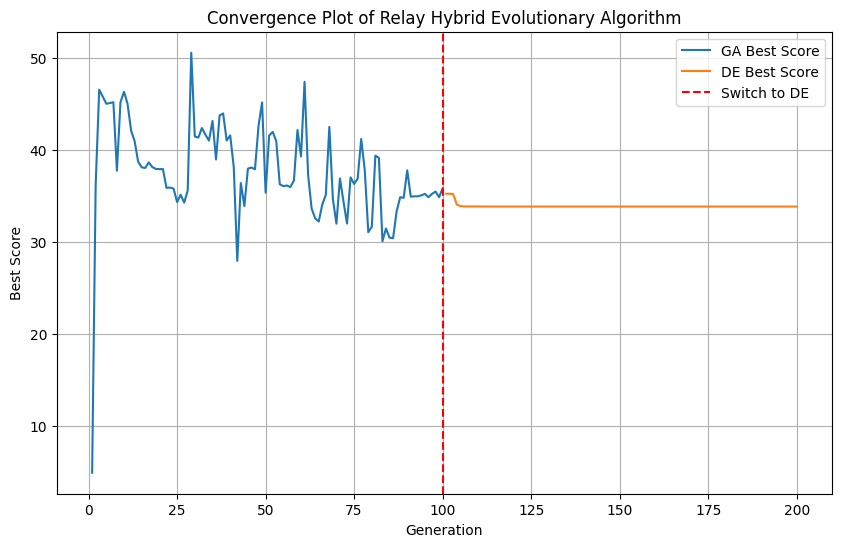

In [12]:
# Plot the outcome
plot_convergence(ga_records, de_records)